A Botnet is a network of Internet devices (i.e. computers, mobile  etc) that have been manipulated to carry out malicious activities.
The owners of such devices are often unaware of this!
These Bots serve the wishes of some master known as Command  & Control


In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
 
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
%%time
#print('script started!',flush=True)
data = pd.read_csv('ISCX_Botnet_Labelled.csv')

Wall time: 9.36 s


In [3]:
data.shape

(10000, 7693)

### Check class distribution .. is it balanced?

In [4]:
# Explore BotNet_Label values
s = data['BotNet_Label'].value_counts()

In [5]:
s

Normal                    4853
Weasel Bot                2158
Virut                     1405
Neris                      742
Murlo                      400
Menti                      163
IRC                        136
Zero access                 71
TBot                        22
Zeus                        14
Black hole 2                14
RBot                         6
Black hole 3                 4
Sogou                        3
IRCbot and black hole1       3
Osx_trojan                   2
Weasel Botmaster             2
Smoke bot                    2
Name: BotNet_Label, dtype: int64

In [6]:
# get a list of labels where the number of instances is > 10
labels = list(s[s > 10].index)

In [7]:
labels

['Normal',
 'Weasel Bot',
 'Virut',
 'Neris',
 'Murlo',
 'Menti',
 'IRC',
 'Zero access',
 'TBot',
 'Zeus',
 'Black hole 2']

In [8]:
# remove BotNets where the number of instances is < 10
data = data[data['BotNet_Label'].isin(labels)]
data['BotNet_Label'].value_counts()

Normal          4853
Weasel Bot      2158
Virut           1405
Neris            742
Murlo            400
Menti            163
IRC              136
Zero access       71
TBot              22
Black hole 2      14
Zeus              14
Name: BotNet_Label, dtype: int64

In [9]:
data.columns

Index(['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean',
       'Fwd IAT Std', 'Fwd IAT Max',
       ...
       'DestPort_63919', 'DestPort_64336', 'DestPort_64939', 'DestPort_64974',
       'DestPort_65500', 'DestPort_65520', 'DestPort_65534', 'Protocol_0',
       'Protocol_6', 'Protocol_17'],
      dtype='object', length=7693)

### Missing value imputation

In [10]:
## FlowGenerator uses ? for a missing value .. let's replace it with NaN
data.replace('?', np.NaN,inplace=True)
print('symbol ? replaced with NaN',flush=True)
# using isnull() function  
data.isnull().values.any()

symbol ? replaced with NaN


True

In [11]:
data.isnull().sum().sum()

1

In [12]:
%%time
## Only run this code if your data contains NaNs
## Replace NaNs with the median of the column

for c in data.columns:
    if c != 'BotNet_Label':
        data[c] = pd.to_numeric(data[c], errors='coerce')
        data[c] = data[c].replace(np.NaN,data[c].median())
#save data so we can use it later
#data.to_csv('no_nans.csv',index=False)
#print('NaN values replaced with median in %f'%(t2-t1),flush=True)

Wall time: 2.87 s


### Plot Correlation Matrix to Check for Highly Correlated Features

In [13]:
## use all columns except protocol and ports to save time
tmp_df = data[['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s','Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 
'Flow IAT Min','Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min','Bwd IAT Mean',
'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min','Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min']]

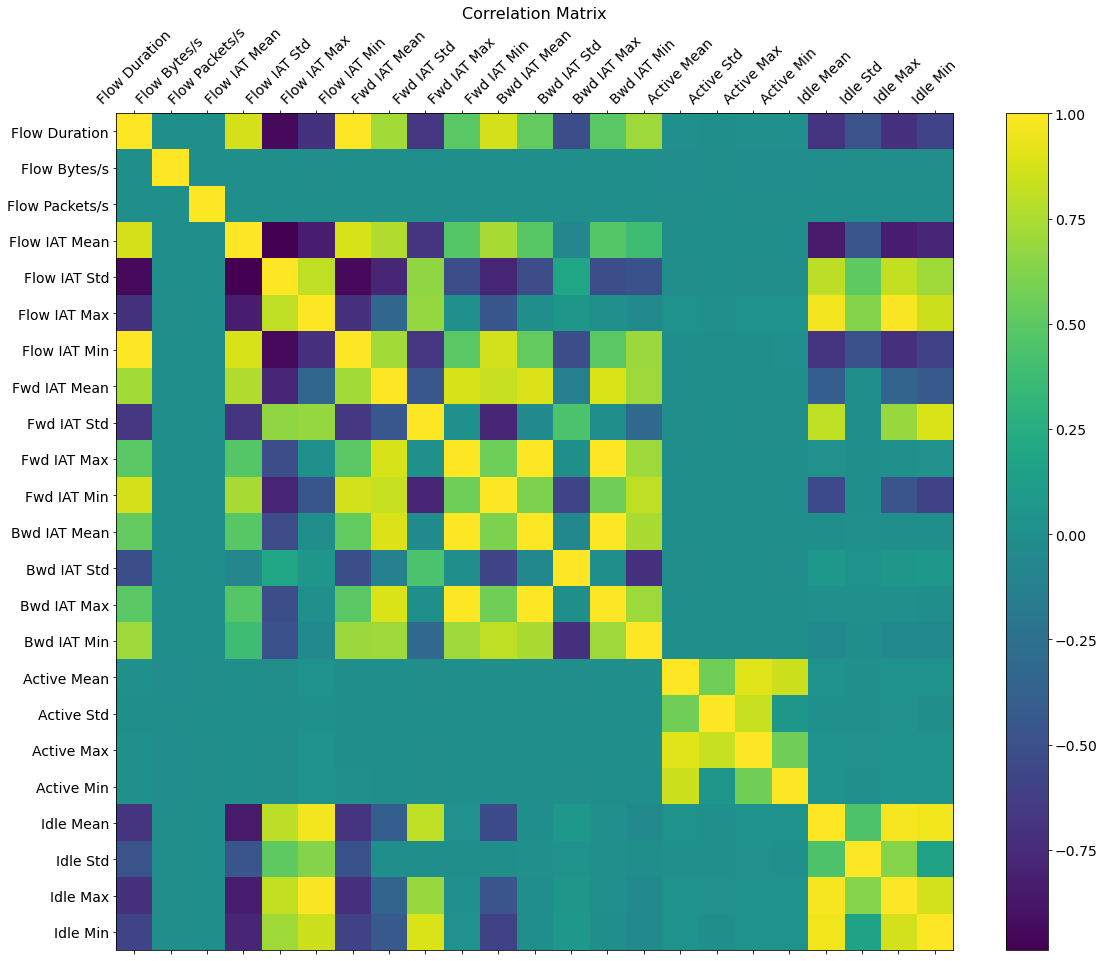

In [14]:
f = plt.figure(figsize=(19, 15))
plt.matshow(tmp_df.corr(), fignum=f.number)
plt.xticks(range(tmp_df.shape[1]), tmp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(tmp_df.shape[1]), tmp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

#### Do it Programmatically

In [15]:
# Create correlation matrix
corr_matrix = tmp_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['Flow IAT Std',
 'Flow IAT Min',
 'Bwd IAT Mean',
 'Bwd IAT Max',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

#### Do you want to drop highly correlated features?

In [16]:
#remove highly correlated columns
data.drop(to_drop,axis=1, inplace=True)

In [17]:
data.columns

Index(['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
       'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Std',
       ...
       'DestPort_63919', 'DestPort_64336', 'DestPort_64939', 'DestPort_64974',
       'DestPort_65500', 'DestPort_65520', 'DestPort_65534', 'Protocol_0',
       'Protocol_6', 'Protocol_17'],
      dtype='object', length=7686)

In [18]:
%%time

Y = data['BotNet_Label']
data.drop('BotNet_Label', axis=1, inplace=True)

#remove single quote from column name
#rm_quote = lambda x: x.replace('\'', '')
#cols = data.columns
#data.columns = [rm_quote(x) for x in cols]

Wall time: 205 ms


### Run Outlier Detection and Removal?

In [19]:
%%time
outliers_fraction = 0.5
rng = np.random.RandomState(42)

# fit the model
#clf = IsolationForest(contamination=outliers_fraction, random_state=rng, n_jobs=60)
#clf = EllipticEnvelope(contamination=outliers_fraction)
clf = LocalOutlierFactor(n_neighbors=25, contamination=outliers_fraction)
y_pred = clf.fit_predict(data)#only for LocalOutlierFactor


data['Outlier'] = y_pred
data['BotNet_Label'] = Y

outlier_mask = data['Outlier'].isin([-1])

print('To apply mask and removed outliters',flush=True)
data = data.loc[~outlier_mask]
data.drop('Outlier', axis=1, inplace=True)
print('data to be saved',flush=True)
#data.to_csv('no_outliers.csv',index=False)


To apply mask and removed outliters
data to be saved
Wall time: 9.41 s


In [20]:
data

,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Std,...,DestPort_64336,DestPort_64939,DestPort_64974,DestPort_65500,DestPort_65520,DestPort_65534,Protocol_0,Protocol_6,Protocol_17,BotNet_Label
0,507,0.000000,5917.159763,2.535000e+02,468.0,253.5,303.348809,468.0,39.0,0.000000,...,0,0,0,0,0,0,0,1,0,Normal
1,4000,27000.000000,500.000000,4.000000e+03,4000.0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,1,Weasel Bot
3,452020,477.854962,4.424583,4.520200e+05,452020.0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,1,Normal
4,777389,231.544311,12.863573,8.637656e+04,693839.0,25282.0,35732.934080,50549.0,15.0,277283.206687,...,0,0,0,0,0,0,0,1,0,Normal
6,4403730,8177.613069,9.991530,1.024123e+05,686258.0,289588.0,308874.238066,908139.0,182.0,240069.297287,...,0,0,0,0,0,0,0,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,11,0.000000,181818.181818,1.100000e+01,11.0,11.0,0.000000,11.0,11.0,0.000000,...,0,0,0,0,0,0,0,1,0,Murlo
9995,91767,0.000000,21.794327,9.176700e+04,91767.0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,1,0,Weasel Bot
9996,11025887,4.534783,0.181391,1.102589e+07,11025887.0,11025887.0,0.000000,11025887.0,11025887.0,0.000000,...,0,0,0,0,0,0,0,0,1,Normal
9997,516788,1400.961323,13.545206,8.613133e+04,279265.0,116479.0,164526.777419,232817.0,141.0,160135.893604,...,0,0,0,0,0,0,0,1,0,Normal


In [21]:
data.shape

(4999, 7686)

In [22]:
#save subdatasets
#labels = list(data['BotNet_Label'].unique())
#for label in labels:
#    tlbl = label.replace(" ", "_")#if label has space replace it with _
#    tdata = data[data['BotNet_Label']==label]
#    tdata.to_csv('Bot_'+tlbl+'.csv',index=False)
#    print('Done: ',label,len(tdata))

#print('all done', flush=True)

In [23]:
data['BotNet_Label'].value_counts()

Normal         2125
Weasel Bot     1508
Virut           615
Neris           305
Murlo           259
Menti            82
IRC              75
Zero access      18
TBot             10
Zeus              2
Name: BotNet_Label, dtype: int64

In [24]:
# Explore BotNet_Label values
s = data['BotNet_Label'].value_counts()

# get a list of labels where the number of instances is > 10
labels = list(s[s > 10].index)

# remove BotNets where the number of instances is < 10
data = data[data['BotNet_Label'].isin(labels)]
data['BotNet_Label'].value_counts()

Normal         2125
Weasel Bot     1508
Virut           615
Neris           305
Murlo           259
Menti            82
IRC              75
Zero access      18
Name: BotNet_Label, dtype: int64

In [25]:
Y.value_counts()

Normal          4853
Weasel Bot      2158
Virut           1405
Neris            742
Murlo            400
Menti            163
IRC              136
Zero access       71
TBot              22
Black hole 2      14
Zeus              14
Name: BotNet_Label, dtype: int64

### SMOTE (Synthetic Minority Oversampling Technique) – Oversampling

* It aims to balance class distribution by randomly increasing minority class examples by replicating them.
* SMOTE synthesises new minority instances between existing minority instances. 
* It generates the virtual training records by linear interpolation for the minority class.
* These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. 

In [26]:
#!pip install -U imbalanced-learn

In [27]:
%%time
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
# separate features from class variable
y = data['BotNet_Label']
X = data.drop('BotNet_Label', axis=1)

X, y = sm.fit_resample(X, y)

Wall time: 7.4 s


In [28]:
y.shape

(17000,)

In [29]:
type(X)

pandas.core.frame.DataFrame

In [30]:
#y.value_counts()

In [31]:
targets = np.unique(y).tolist()
len(targets)

8

### Principal Component Analysis (PCA)

In [32]:
# Apply StandardScaler
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [33]:
# Apply PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
# create a datarame that contains the PCA components
principal_df = pd.DataFrame(data = principal_components, columns=['principal component 1','principal component 2'])

In [34]:
# add the class label to the PCA components
principal_df['BotNet_Label'] = y

In [35]:
principal_df.head()

,principal component 1,principal component 2,BotNet_Label
0,-0.588624,1.353685,Normal
1,-1.145618,-2.397987,Weasel Bot
2,-1.074104,-2.337165,Normal
3,-0.621214,0.998708,Normal
4,-0.495510,0.972782,Normal


In [36]:
principal_df['BotNet_Label'].value_counts()

Neris          2125
IRC            2125
Virut          2125
Normal         2125
Murlo          2125
Zero access    2125
Menti          2125
Weasel Bot     2125
Name: BotNet_Label, dtype: int64

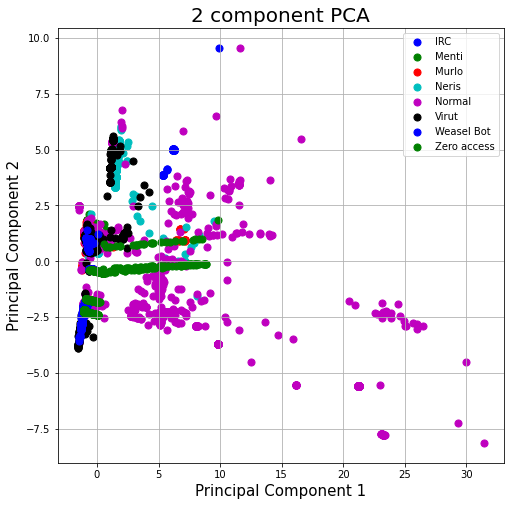

In [37]:
from itertools import cycle

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Neris', 'Normal', 'TBot', 'RBot']
#colors = ['r', 'g', 'b','c']


cycol = cycle('bgrcmk')

    
for target in targets:
    indicesToKeep = principal_df['BotNet_Label'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2']
               , c = next(cycol)
               , s = 50)
ax.legend(targets)
ax.grid()

In [38]:
targets

['IRC',
 'Menti',
 'Murlo',
 'Neris',
 'Normal',
 'Virut',
 'Weasel Bot',
 'Zero access']

### Use your Favourite Classifier to Make Predictions

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

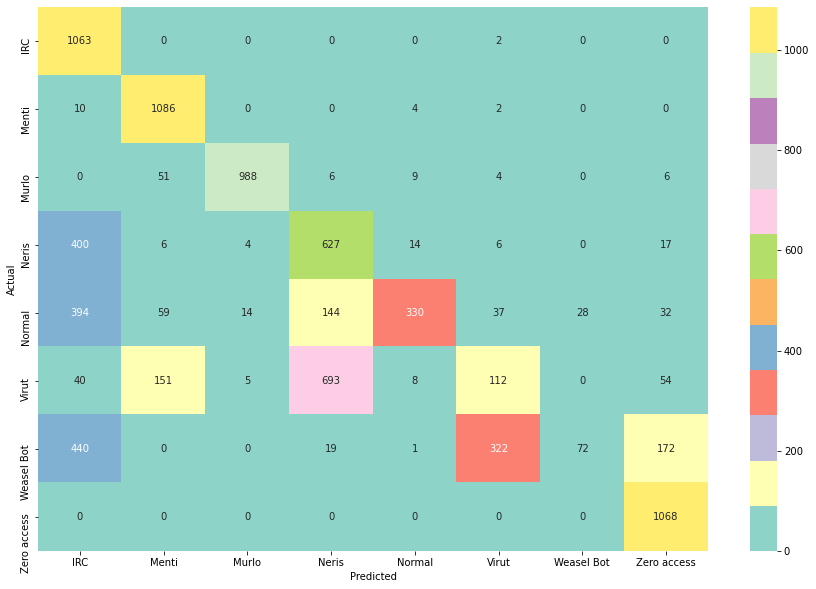

Wall time: 6.72 s


In [40]:
%%time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = gnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)


# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=targets, yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [41]:
from sklearn.metrics import accuracy_score

print("Accuracy: " , (accuracy_score(y_test, y_pred)))

Accuracy:  0.6289411764705882


# Well Done!